In [20]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pywt
import os
from os import listdir
from os.path import isfile, join
from os import walk

In [4]:
img = cv2.imread('C://Users//adist//OneDrive//Pictures//kk.png')
img.shape

(270, 270, 3)

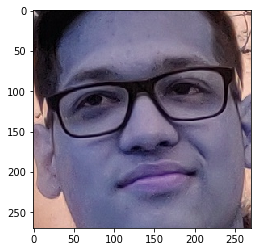

In [5]:
plt.imshow(img)

In [7]:
def w2d(img,mode='haar',level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray) 
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    
    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;
    
    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

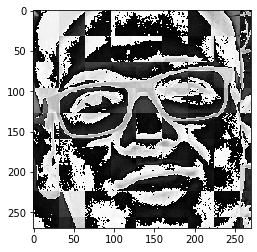

In [8]:
im_har = w2d(img,'db1',5)
plt.imshow(im_har,cmap='gray')

In [9]:
name_labels = {'aditya':0,'anshul':1,'anurag':2,'puru':3,'varsha':4}
name_labels

{'aditya': 0, 'anshul': 1, 'anurag': 2, 'puru': 3, 'varsha': 4}

##### Cropped Images can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [13]:
data_path = 'C://Users//adist//OneDrive//Pictures//cropped//'

In [39]:
fil = {}
for direc in listdir(data_path):
    f = []
    for img in listdir(join(data_path,direc)):
        f.append(join(data_path,direc,img))
    fil[direc] = f

In [40]:
X,y = [],[]
for names,files in fil.items():
    for fil in files:
        img = cv2.imread(fil)
        scaled = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scaled_har = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scaled.reshape(32*32*3,1),scaled_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(name_labels[names])

In [41]:
len(X[0])

4096

In [42]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(146, 4096)

## TRAIN MODEL

In [45]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.7567567567567568

In [47]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.89      0.80      0.84        10
           2       0.86      0.67      0.75         9
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         6

    accuracy                           0.76        37
   macro avg       0.82      0.81      0.79        37
weighted avg       0.82      0.76      0.76        37



In [48]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [49]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.704329,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.576190,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.722511,{'logisticregression__C': 1}


In [51]:
best_estimators

{'svm': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svc',
                  SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='auto', kernel='linear', max_iter=-1,
                      probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False),
 'random_forest': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                   

In [52]:
best_estimators['svm'].score(X_test,y_test)

0.7837837837837838

In [54]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7567567567567568

Text(69.0, 0.5, 'Truth')

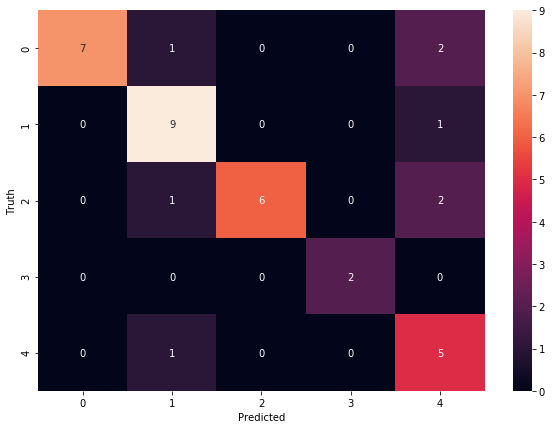

In [59]:
from sklearn.metrics import confusion_matrix
best_clf = best_estimators['svm']
cm = confusion_matrix(y_test,best_clf.predict(X_test))

import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
name_labels

{'aditya': 0, 'anshul': 1, 'anurag': 2, 'puru': 3, 'varsha': 4}

## SAVING THE BEST MODEL

In [63]:
!pip install joblib
import joblib
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [65]:
import json
with open('class_dictionary.json','w') as f:
    f.write(json.dumps(name_labels))